# Mushrooms ML competition

A sample solution using `predict_proba` and the ROC curve.

## 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix


from sklearn.ensemble import RandomForestClassifier

## 2. Read, manipulate and split data

In [2]:
url = 'https://drive.google.com/file/d/1Op1vQftBKN1lrPVGGLJU-UOlv_dScTup/view?usp=sharing' # train.csv
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
mush = pd.read_csv(path)

In [3]:
url = 'https://drive.google.com/file/d/16S9TzU3JkhwlGhXczibK9f2UbgNaHdM3/view?usp=sharing' # test.csv
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
mush_test = pd.read_csv(path)

In [4]:
mush.drop('Id',axis=1,inplace=True)

In [5]:
mush_test.set_index('Id',inplace=True)

In [6]:
X = mush.drop(columns=['poisonous'])
y = mush['poisonous']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)
X_train.head()

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population
1725,f,g,True,w,p,y
1260,f,g,True,g,g,v
4551,x,y,False,p,b,y
2442,f,c,False,w,n,v
6109,x,g,True,g,w,v


## 3. Pipeline

We have chosen the `RandomForestClassifier()` as our model but you can try any other classifier.

In [7]:
cat_col= list(X_train.select_dtypes(include=["object"]))
cat_col

['cap.shape',
 'cap.color',
 'stalk.color.above.ring',
 'stalk.color.below.ring',
 'population']

In [8]:
categorical_pipeline = Pipeline(steps=[
    ('one-hot', OneHotEncoder(handle_unknown='ignore'))
])

full_processor = ColumnTransformer(transformers=[
    ('category', categorical_pipeline, cat_col)
])

In [9]:
rf_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', RandomForestClassifier(n_estimators=500, random_state=123))
])

In [10]:
_ = rf_pipeline.fit(X_train, y_train)

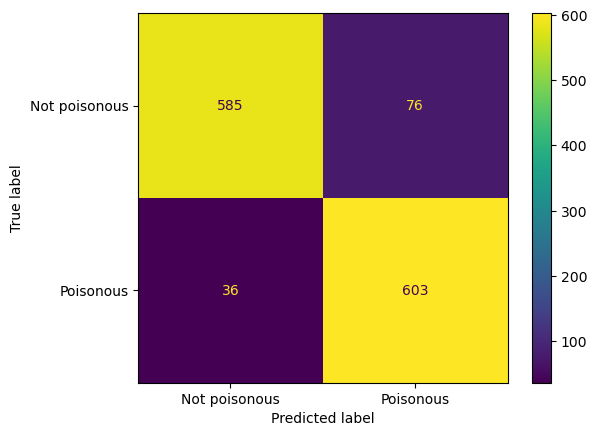

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    rf_pipeline, X_test, y_test, display_labels=['Not poisonous', 'Poisonous']);

The confusion matrix shows that our model predicted 36 False negatives, which means 36 poisonous mushrooms will be predicted as non-poisonous. Our task is to avoid these situations at all costs, so we need to find a way to make that left-bottom corner of confusion matrix to be 0.

## 4. Probabilities with `predict_proba()`

In this notebook we will try to change threshold with which we are predicting our classes.

**What is a threshold?**

It is a value above or below which a model predicts a different class.  
The default threshold is `0.5`, which means that if a sample has a `0.51` chance to be class 0 and a `0.49` chance to be class 1, the model will predict that sample as class 0.

In our case, this can be very dangerous because a `0.49` chance that a mushroom is poisonous is still a high chance, but our model with the default threshold will still predict it as non-poisonous.

If you're intending to eat a mushroom, would you prefer that it is labeled as poisonous even if it's non-poisonous, or that it is labeled non-poisonous even if it's poisonous?

Uneaten non-poisonous mushrooms are a pity, but eaten poisonous mushrooms are a deathly risk.

After moving threshold this will indeed happen:  
A lot of non-poisonous might be labeled poisonous and they will be left uneaten, but at least no poisonous will be labeled non-poisonous and noone will die!

The **`predict_proba()`** method will help us with our task.
 

`predict_proba()` is a method that many Scikit-Learn classification models have, including `LogisticRegression`, `KNeighborsClassifier`, `DecisionTreeClassifier` or the one we'll use in our example, `RandomForestClassifier`. (You can check what methods any Scikit-Learn transformer/model have by just looking at its documentation.) As [the documentation for that method outlines](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba), after fitting one of the mentioned models to the data,  `predict_proba()` will return the probabilities of each sample to belong to each possible class.

In our case, for each mushroom, `predict_proba()` will tell us probability of that mushroom being non-poisonous (class 0) and poisonous (class 1). Let's have a look:

In [ ]:
rf_proba = rf_pipeline.predict_proba(X_test)
pd.DataFrame(rf_proba)

,0,1
0,0.590304,0.409696
1,1.000000,0.000000
2,0.151588,0.848412
3,0.000000,1.000000
4,0.132549,0.867451
...,...,...
1295,1.000000,0.000000
1296,0.154944,0.845056
1297,1.000000,0.000000
1298,1.000000,0.000000


The `rf_proba` array has a shape of (1300,2):
* 1300 is a number of mushroooms in our X-test set  
* 2 is a number of classes, in our case 0 and 1 (non-poisonous and poisonous)  

The first column holds the values of probabilites for a mushroom being class 0  
The second column holds the values of probabilites for a mushroom being class 1

In [ ]:
rf_proba = rf_proba[:,1]
# if we select only the second column we will select all probabilities for our test mushrooms to be poisonous

## 5. ROC and threshold selection

ROC and AUC will help us with choosing the treshold. Please, go through these links to learn about these important metrics for binary classification. It will help you understand the rest of the notebook:  
* https://www.kaggle.com/getting-started/53782  
* https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/  
* https://www.youtube.com/watch?v=4jRBRDbJemM

The `roc_curve()` function computes the results of many models using several different thesholds, from 0 to 1. Then, it returns three arrays:

1. An array with false positive rates.
2. An array with true positive rates.
3. An array with the threshold that determines the results obtained in the two previous arrays.

More on the `roc_curve()` function here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html  

In [ ]:
from sklearn.metrics import roc_curve

rf_fpr, rf_tpr, rf_threshold = roc_curve(y_test, rf_proba)

We can create a dataframe with fpr, tpr and threshold arrays that we got from roc_curve function and visualize the roc plot as well.

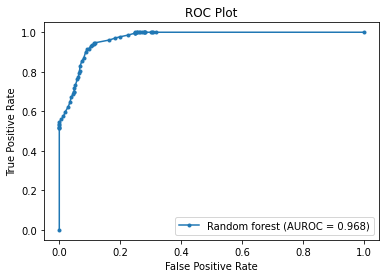

In [ ]:
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test,rf_proba)

plt.plot(rf_fpr, rf_tpr, marker='.', label='Random forest (AUROC = %0.3f)' % rf_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

We can see on above ROC plot that True positive rate becomes 1 when False positive rate is around 0.3. Let's see what is the value of threshold when True positive rate is 1.

In [ ]:
win_threshold = pd.DataFrame({'fpr':rf_fpr,'tpr':rf_tpr,'threshold':rf_threshold})
win_threshold

,fpr,tpr,threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.514867,1.000000
2,0.000000,0.516432,0.999478
3,0.000000,0.519562,0.998000
4,0.000000,0.532081,0.929049
5,0.000000,0.535211,0.914652
6,0.000000,0.544601,0.904460
7,0.006051,0.558685,0.867451
8,0.013616,0.574335,0.861962
9,0.019667,0.597809,0.848412


Lets take one row of above DataFrame to explain the values

In [ ]:
win_threshold.loc[15]

fpr          0.048411
tpr          0.697966
threshold    0.814983
Name: 15, dtype: float64

This row means that if we set the threshold as `0.81`, the false positive rate will be `0.05` and true positive rate will be `0.7`.

It means that for that theshold, 5% of all non-poisonous mushrooms will be (incorrectly) labaled as poisonous, and 70% of all poisonous mushrooms will be correctly labeled as such.

Since our task is to NOT predict poisonous as non-poisonous, which means, we should have 0 False negatives, our True positive rate has to be 1 (100% of poisonous get labeled as poisonous).  
Visually examining the above DataFrame we can se that TPR is increasing from 0 to 1 and finally reaches 1 in the row 40. In that same row, the threshold value is `0.25`, and that is the one we will choose to filter our results.

In [ ]:
win_threshold_value= win_threshold.threshold[40]
win_threshold_value

0.2529542397452717

We encourage you to scan the results shown above, but here's a slightly more automated way to find the best threshold:

In [ ]:
win_threshold[win_threshold.tpr==1].sort_values("threshold", ascending=False).head(1)

,fpr,tpr,threshold
40,0.249622,1.0,0.252954


## 6. Adjusting the predictions based on treshold value - X-test

The following code is filtering predicted values based on the probability 
of a sample being a class 1 (of a mushroom to be poisonous) that `predicted_proba()` returned.

If a value is higher than the threshold it will set prediction as 1 (poisonous). Only if a probability is lower than the threshold it will predicted as 0 (non-poisonous).

In [ ]:
predicted_proba = rf_pipeline.predict_proba(X_test)

predicted = (predicted_proba [:,1] >= win_threshold_value).astype('int')

In [ ]:
# just the sample so you can see how values are set based on predicted_proba values:
print(f'Probability: {predicted_proba [:5,1]}')
print(f'Set value: {predicted[:5]}')

Probability: [0.40969587 0.         0.84841232 1.         0.86745138]
Set value: [1 0 1 1 1]


## 7. Confusion matrix of adjusted results

In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predicted)

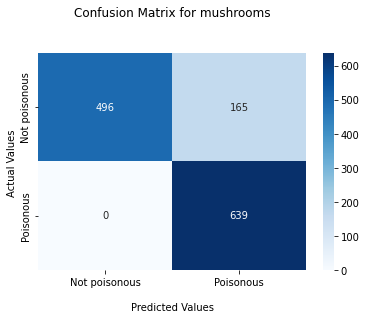

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix for mushrooms\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Not poisonous','Poisonous'])
ax.yaxis.set_ticklabels(['Not poisonous','Poisonous'])

## Display the visualization of the Confusion Matrix.
plt.show()

## 8. Adjusting the predictions based on threshold value - test

Now we can do the same on a real test set that we want to predict:

In [ ]:
predicted_proba_test = rf_pipeline.predict_proba(mush_test)
predicted_test = (predicted_proba_test [:,1] >= win_threshold_value).astype('int')

## 9. Creating a submission file

In [ ]:
submission_file = pd.DataFrame({'Id': mush_test.index, 'poisonous': pd.Series(predicted_test)})
submission_file

,Id,poisonous
0,5165,1
1,4281,1
2,231,1
3,3890,1
4,1521,1
...,...,...
1620,983,1
1621,7055,0
1622,7456,1
1623,5132,0


In [ ]:
# submission_file.to_csv('submission.csv', index=None )